###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2024 Semester 1

## Assignment 1: Wine quality classification with K-NN


**Student ID(s):**     1356294


##### Readme Instructions on how to run code
Run the code blocks in order to generate the needed graphs and make sure the files winequaility-test.csv and winequality-train.csv are in the same directory as this file

## 1. K-NN classifier

In [16]:
# import required libraries
import pandas as pd
import numpy as np
from typing import Callable
from tabulate import tabulate

wine_test = pd.read_csv('winequality-test.csv')
wine_train = pd.read_csv('winequality-train.csv')


In [17]:
def majority_vote(neighbors: pd.DataFrame, K: int, toPrint=False) -> int:
    """determines the majority vote for a given set of neighbors

    Args:
        neighbors (pd.DataFrame): neighbours of the test data with a 'distance' attribute
        K (int): _description_
    Returns:
        int: _description_
    """

     # Sort by distance and select top K
    nearest_neighbors = neighbors.sort_values("Distance").iloc[:K]

    # Majority vote
    most_common = nearest_neighbors.iloc[:, -2].mode()

    if(toPrint):
        print(np.array(nearest_neighbors.groupby('quality').size()))

    if len(most_common) > 1:
        # Resolve ties by choosing the closest one
        return nearest_neighbors.iloc[0, -2]
    else:
        return most_common.iloc[0]
    

def Euclidian_Distance(train: pd.DataFrame, test: pd.DataFrame) -> np.array:
    """Calculates euclidian distance of each test data point from each train data point - for every element in train

    Args:
        train (pd.DataFrame): the training data
        test (pd.DataFrame): the test data

    Returns:
        np.array: array containing all distances
    """

    distances = np.sqrt(np.sum((np.array(train) - np.array(test)) ** 2, axis=1))

    return distances

def Knn_Classifier(K: int, train: pd.DataFrame, test: pd.DataFrame, weighting: Callable[[pd.DataFrame,int],int] = majority_vote, distance_metric: Callable[[pd.DataFrame,pd.DataFrame],np.array] = Euclidian_Distance) -> np.array:
    '''
    This function implements a KNN classifier. It takes in the following arguments:
    K (int) : the number of nearest neighbors to consider
    train (pd.DataFrame): a df containing the train data
    test (pd.DataFrame): a df containing the test data
    '''

    # ensure that the train and test data are of the same shape
    assert train.shape[1] == test.shape[1]

    train_data = train.iloc[:, :-1]
    test_data = test.iloc[:, :-1]

    train_copy: pd.DataFrame = train.copy()


    # ensure that Knn is less than the number of rows in the train data
    assert K <= train.shape[0]

    # list to store the predicted values
    predictions : np.array = np.array([])


    for index, row in test_data.iterrows():
        # Calculate Euclidean distance
        distances = distance_metric(train_data, row)
        train_copy['Distance'] = distances

        predictions = np.append(predictions, weighting(train_copy, K))


    return predictions

## 2. 1-NN classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

In [18]:
predictions = Knn_Classifier(1,pd.read_csv('winequality-train.csv'), pd.read_csv('winequality-test.csv'))

test : pd.DataFrame = pd.read_csv('winequality-test.csv')


# check the accuracy
def compute_accuracy(predictions: pd.Series, actual: pd.Series) -> float:
    """Computes the probabiltiy of a model by looking at the number of correct predictions

    Args:
        predictions (pd.Series): the predictions of the model as a series
        actual (pd.Series): the actual values as a series

    Returns:
        float: _description_
    """

    predictions = np.array(predictions)
    actual = np.array(actual)

    return np.sum(predictions == actual) / len(actual)


results = pd.DataFrame({
    'Method': ["1-NN"],
    "accuracy": [compute_accuracy(pd.Series(predictions) , test['quality'])]
})

print(tabulate(results, headers='keys', tablefmt='fancy_grid', showindex=False))



╒══════════╤════════════╕
│ Method   │   accuracy │
╞══════════╪════════════╡
│ 1-NN     │   0.764444 │
╘══════════╧════════════╛


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

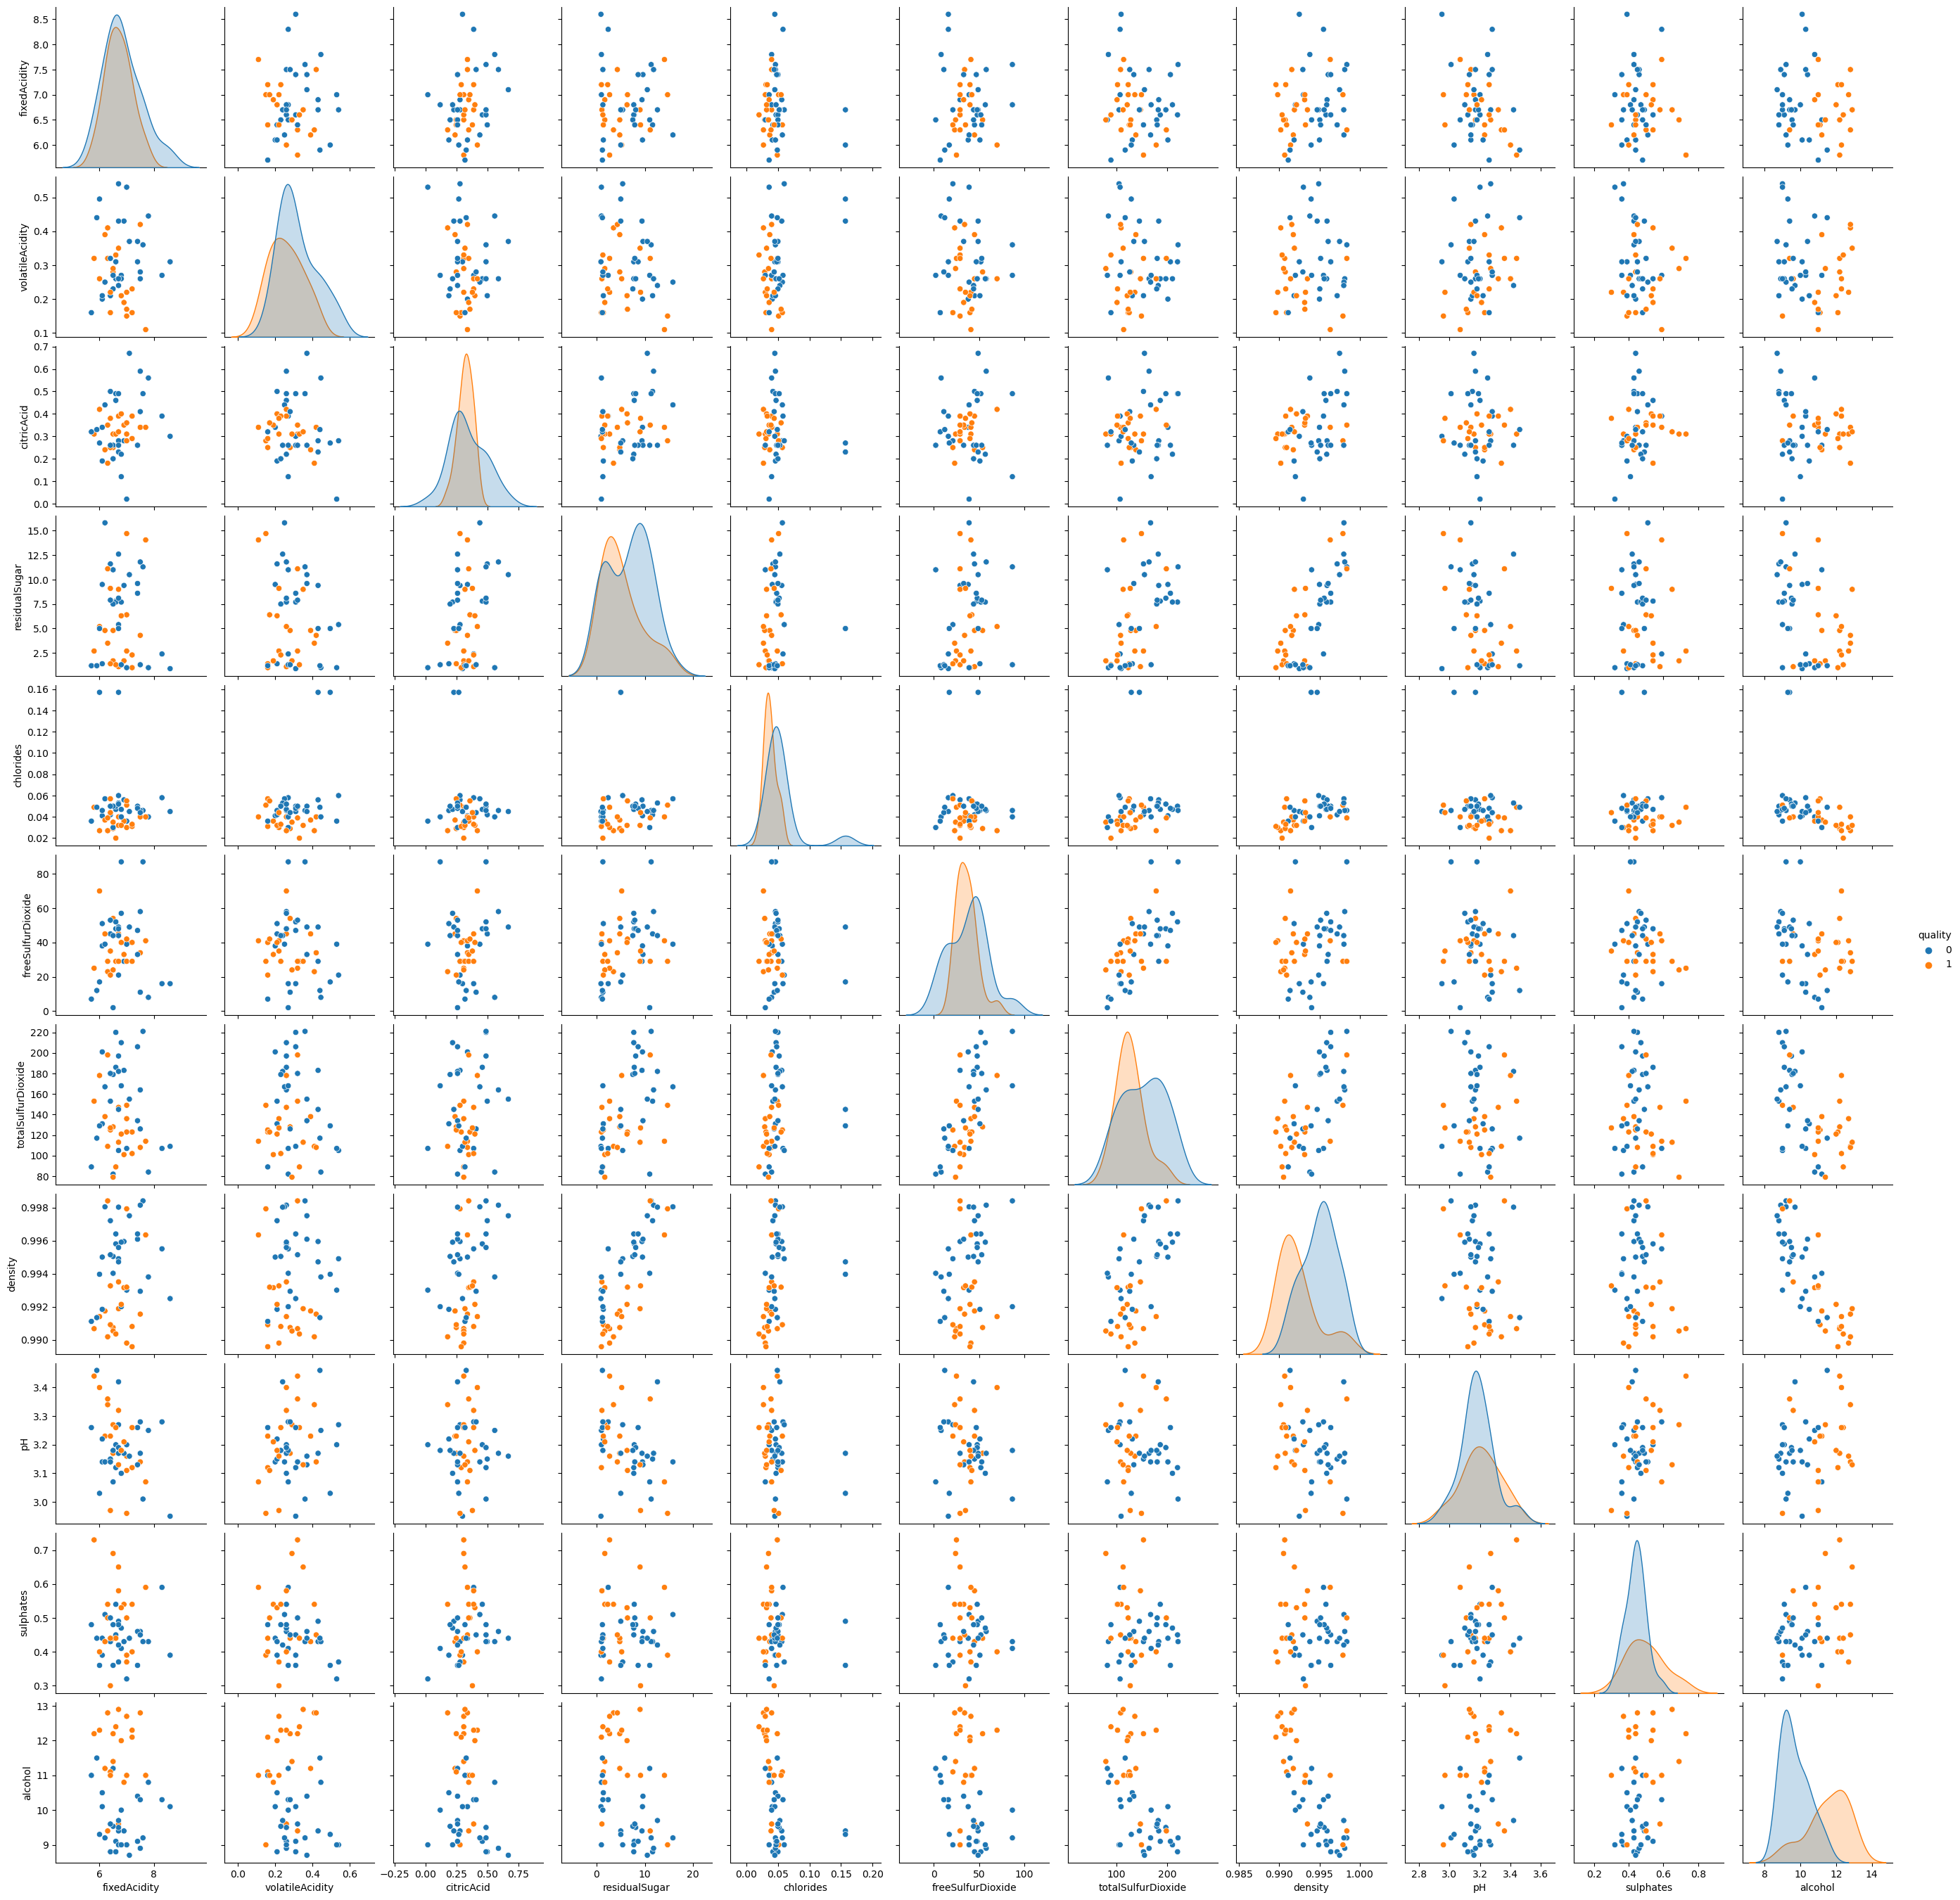

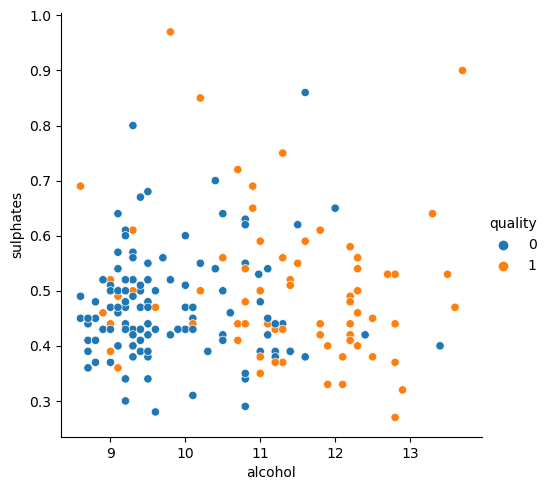

In [19]:
# Import seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# get the data to plot
train = pd.read_csv('winequality-train.csv')
sample = train.sample(200)


# create pairplot to visualize the data
sns.pairplot(train.sample(50), hue='quality')

# chose alcohol and sulphates as the features to plot
sns.relplot(x='alcohol', y='sulphates', hue='quality', data=sample)

## 3. Normalization

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

In [20]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

Xtrain = train.iloc[:,:-1]
ytrain = train.iloc[:,-1]

Xtest = test.iloc[:,:-1]
ytest = test.iloc[:,-1]

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)


knn = KNeighborsClassifier(n_neighbors=1, weights='uniform')
knn.fit(Xtrain, ytrain)



y_pred = knn.predict(Xtest)
accuracy = accuracy_score(ytest, y_pred)
print(tabulate({"Method": ["1-NN"], "accuracy": [accuracy]}, headers='keys', tablefmt='fancy_grid', showindex=False))

0.8674074074074074


In [21]:
# 1. Min-Max scaling attributes
def min_max_scaling(train: pd.DataFrame, test: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    assert train.shape[1] == test.shape[1]
    train_without_quality = train.drop(columns='quality', inplace=False)
    cols = train_without_quality.columns

    new_train: pd.DataFrame = pd.DataFrame()
    new_test: pd.DataFrame = pd.DataFrame()
    for col in cols:
        new_train[col] = (train[col] - train[col].min()) / (train[col].max() - train[col].min())
        new_test[col] = (test[col] - train[col].min()) / (test[col].max() - train[col].min())
    
    new_test['quality'] = test['quality']
    new_train['quality'] = train['quality']
    return new_train, new_test
    

# 2. Standard scaling attributes
def standard_scaling(train: pd.DataFrame, test: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    assert train.shape[1] == test.shape[1]
    train_without_quality = train.drop(columns='quality', inplace=False)
    cols = train_without_quality.columns

    new_train: pd.DataFrame = pd.DataFrame()
    new_test: pd.DataFrame = pd.DataFrame()

    
    for col in cols:
        new_train[col] = (train[col] - train[col].mean()) / train[col].std()
        new_test[col] = (test[col] - train[col].mean()) / train[col].std()
    
    new_test['quality'] = test['quality']
    new_train['quality'] = train['quality']
    return new_train, new_test

min_max_labels = Knn_Classifier(1, *min_max_scaling(wine_train, wine_test))
standard_scaling_labels = Knn_Classifier(1, *standard_scaling(wine_train, wine_test))
#normal_labels = Knn_Classifier(1, wine_train, wine_test)


#print(standard_scaling(wine_train, wine_test)[1].head(5))

results = pd.DataFrame({
    'Method': ['Min-Max Scaling', 'Standard Scaling'],
    'Accuracy': [
        compute_accuracy(pd.Series(min_max_labels), wine_test['quality']),
        compute_accuracy(pd.Series(standard_scaling_labels), wine_test['quality'])
    ]
})

# Print the DataFrame
print(tabulate(results, headers='keys', tablefmt='fancy_grid', showindex=False))



╒══════════════════╤════════════╕
│ Method           │   Accuracy │
╞══════════════════╪════════════╡
│ Min-Max Scaling  │   0.844444 │
├──────────────────┼────────────┤
│ Standard Scaling │   0.867407 │
╘══════════════════╧════════════╛


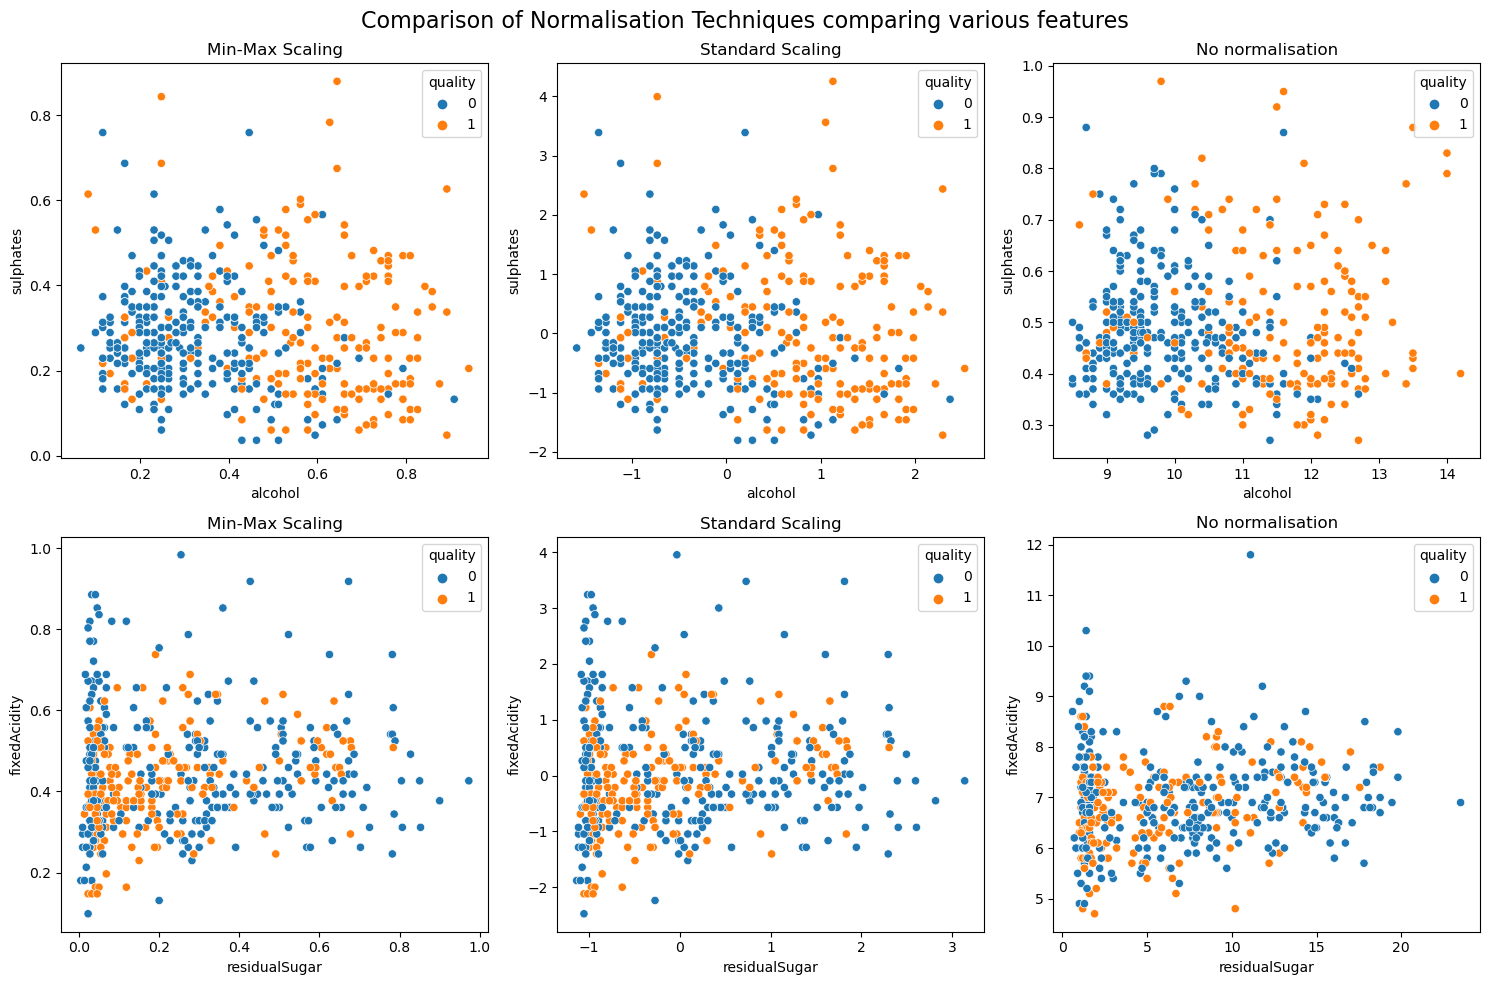

In [22]:

# Create pairplot to visualise data
#sns.pairplot(min_max_scaling(wine_train,wine_test)[1].sample(50), hue='quality')
#sns.pairplot(standard_scaling(wine_train,wine_test)[1].sample(50), hue='quality')

sample_number = 500

# Choose alcohol and sulphates as the features to plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Comparison of Normalisation Techniques with sample n=500 (random state=1) comparing Sulphates and Alcohol')

axes[0,0].set_title('Min-Max Scaling')
axes[0,1].set_title('Standard Scaling')
axes[0,2].set_title('No normalisation')

sns.scatterplot(x='alcohol', y='sulphates', hue='quality', data=min_max_scaling(wine_train,wine_test)[1].sample(500, random_state=1), ax=axes[0,0])
sns.scatterplot(x='alcohol', y='sulphates', hue='quality', data=standard_scaling(wine_train,wine_test)[1].sample(500, random_state=1),ax=axes[0,1])
sns.scatterplot(x='alcohol', y='sulphates', hue='quality', data=wine_train.sample(500, random_state=1), ax=axes[0,2])

axes[1,0].set_title('Min-Max Scaling')
axes[1,1].set_title('Standard Scaling')
axes[1,2].set_title('No normalisation')

fig.suptitle('Comparison of Normalisation Techniques comparing various features', fontsize=16)


sns.scatterplot(x='residualSugar', y='fixedAcidity', hue='quality', data=min_max_scaling(wine_train,wine_test)[1].sample(500, random_state=1), ax=axes[1,0])
sns.scatterplot(x='residualSugar', y='fixedAcidity', hue='quality', data=standard_scaling(wine_train,wine_test)[1].sample(500, random_state=1),ax=axes[1,1])
sns.scatterplot(x='residualSugar', y='fixedAcidity', hue='quality', data=wine_train.sample(500, random_state=1), ax=axes[1,2])

plt.tight_layout()
plt.show()

## 4. Model extensions

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### 4.1
Compare the performance of your best 1-NN model from Question 3 to a Gaussian naive Bayes model on this dataset (you may use library functions to implement the Gaussian naive Bayes model). In your write-up, state the accuracy of the naive Bayes model and identify instances where the two models disagree. Why do the two models classify these instances differently?

### 4.2
Implement two additional distance measures for your K-NN model: cosine similarity and Mahalanobis distance (you may use library functions for these distance measures). Do 1-NN classification using each of these new distance measures and the three normalization options from Question 3. Discuss how the new distance metrics compare to Euclidean distance and how each metric is affected by normalization.

In [23]:
def cosine_similariy(train: pd.DataFrame, test: pd.DataFrame) -> np.array:
    """Calculates the cosine similarity of each test data point from each train data point - for every element in train

    Args:
        train (pd.DataFrame): dataframe containing train data
        test (pd.DataFrame): dataframe containing elements to test against train data

    Returns:
        np.array: an array containing all the cosine similarities
    """

    train = np.array(train)
    test = np.array(test)


    # Calculate the magnitude of train vector
    train_magnitude = np.linalg.norm(train, axis=1)
    test_magnitude = np.linalg.norm(test)

    # Calculate the cosine similarity
    cosine_similarity = np.dot(train, test) / (train_magnitude * test_magnitude)


    # 1 - cosine similarity gives the cosine distance
    return 1 - cosine_similarity

def mahalanobis_distance(train: pd.DataFrame, test: pd.DataFrame) -> np.array:
    """calculates mahalanobis_distance for train and test data

    Args:
        train (pd.DataFrame): data containing a single element to test against
        test (pd.DataFrame): data containing the whole training set

    Returns:
        np.array: _description_
    """

    train: np.array = np.array(train)
    test: np.array = np.array(test)

    diff: np.array = train - test

    inv_cov_matrix = np.linalg.inv(np.cov(train.T))

    # Initialize an array to store the Mahalanobis distances
    distances = np.zeros(train.shape[0])

    for i, test_point in enumerate(train):
        diff = test_point - test  # Difference from the mean of the training data
        distances[i] = np.sqrt(np.dot(np.dot(diff.T, inv_cov_matrix), diff))

    return distances




# Create an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Normalization', 'Cosine Accuracy', 'Mahalanobis Accuracy'])

rows = []

for train_test, name in zip([min_max_scaling(wine_train, wine_test), 
                             standard_scaling(wine_train, wine_test), 
                             (wine_train, wine_test)], 
                            ['Min-Max Scaling', 'Standard Scaling', 'No Normalisation']):
    train, test = train_test

    cosine_labels = Knn_Classifier(1, train, test, distance_metric=cosine_similariy)
    mahalanbois_labels = Knn_Classifier(1, train, test, distance_metric=mahalanobis_distance)

    cosine_accuracy = compute_accuracy(pd.Series(cosine_labels), test["quality"])
    mahalanobis_accuracy = compute_accuracy(pd.Series(mahalanbois_labels), test["quality"])

    # Create a new row as a DataFrame and add it to the list
    new_row = pd.DataFrame({'Normalization': [name], 'Cosine Accuracy': [f'{cosine_accuracy:.5f}'], 'Mahalanobis Accuracy': [f'{mahalanobis_accuracy:.2f}']})
    rows.append(new_row)

# Concatenate all rows into the results DataFrame
results_df = pd.concat(rows, ignore_index=True)

# Print the DataFrame using tabulate
print(tabulate(results_df, headers='keys', tablefmt='fancy_grid', showindex=False))



╒══════════════════╤═══════════════════╤════════════════════════╕
│ Normalization    │   Cosine Accuracy │   Mahalanobis Accuracy │
╞══════════════════╪═══════════════════╪════════════════════════╡
│ Min-Max Scaling  │           0.8363  │                   0.77 │
├──────────────────┼───────────────────┼────────────────────────┤
│ Standard Scaling │           0.86444 │                   0.86 │
├──────────────────┼───────────────────┼────────────────────────┤
│ No Normalisation │           0.77037 │                   0.86 │
╘══════════════════╧═══════════════════╧════════════════════════╛


### 4.3
Implement either of the two K-NN weighting strategies discussed in lecture (inverse linear distance or inverse distance). Compare the performance of the weighted and majority vote models for a few different values of K. In your write-up, discuss how weighting strategy and the value of K affect the model's decisions.

In [24]:
pd.options.mode.chained_assignment = None

def inverse_distance(neigbours : pd.DataFrame, K: int, toPrint=False) -> int:
    # Sort by distance and select top K
    nearest_neighbours = neigbours.sort_values("Distance").iloc[:K]

    epsilon = 0.000001

    # Inverse distance weighting
    nearest_neighbours['weight'] = 1 / (nearest_neighbours['Distance'] + epsilon)
    
    weighted_sums = nearest_neighbours.groupby('quality')['weight'].sum()

    if(toPrint):
        print(np.array(weighted_sums))

    return weighted_sums.idxmax()

def inverse_linear_distance(neigbours: pd.DataFrame, K: int, toPrint=False) -> int:

    # Sort by distance
    nearest_neighbours: pd.DataFrame = neigbours.sort_values("Distance")

    # find max and minimum
    maxium_distance: float = nearest_neighbours['Distance'].max()
    minimum_distance: float = nearest_neighbours['Distance'].min()



    # nearest K neighbours
    nearest_k_neighbours: pd.DataFrame = nearest_neighbours.iloc[:K]

    # calculate the weights
    nearest_k_neighbours['weights'] =  nearest_k_neighbours['Distance'].apply(lambda x: (maxium_distance - x) / (maxium_distance - minimum_distance))

    weighted_sums = nearest_k_neighbours.groupby('quality')['weights'].sum()

    if(toPrint):
        print(np.array(weighted_sums))

    return weighted_sums.idxmax()

In [27]:
train, test = standard_scaling(wine_train, wine_test)
k = 10


accuracy_data = {
        'Method': ['Accuracy of inverse distance', 'Accuracy of linear inverse distance', 'Accuracy of majority vote']}

for k in [3,50,100,200]:

    # Predictions for different classifiers
    prediction_inverse = Knn_Classifier(k, train,test, weighting=inverse_distance)
    prediction_linear = Knn_Classifier(k, train, test, weighting=inverse_linear_distance)
    prediction_normal = Knn_Classifier(k, train, test, weighting=majority_vote)


    accuracy_data[f'Accuracy (K={k})'] = [
        compute_accuracy(pd.Series(prediction_inverse), wine_test["quality"]),
        compute_accuracy(pd.Series(prediction_linear), wine_test["quality"]),
        compute_accuracy(pd.Series(prediction_normal), wine_test["quality"])
    ]
    

    table_title = f"\n\nComparison of Different Accuracy Metrics for K={k} and Standard Scaling\n"


print(table_title)
print(tabulate(accuracy_data, headers='keys', tablefmt='fancy_grid', showindex=False))







Comparison of Different Accuracy Metrics for K=200 and Standard Scaling

╒═════════════════════════════════════╤══════════════════╤═══════════════════╤════════════════════╤════════════════════╕
│ Method                              │   Accuracy (K=3) │   Accuracy (K=50) │   Accuracy (K=100) │   Accuracy (K=200) │
╞═════════════════════════════════════╪══════════════════╪═══════════════════╪════════════════════╪════════════════════╡
│ Accuracy of inverse distance        │         0.868148 │          0.873333 │           0.857778 │           0.84963  │
├─────────────────────────────────────┼──────────────────┼───────────────────┼────────────────────┼────────────────────┤
│ Accuracy of linear inverse distance │         0.847407 │          0.841481 │           0.814815 │           0.8      │
├─────────────────────────────────────┼──────────────────┼───────────────────┼────────────────────┼────────────────────┤
│ Accuracy of majority vote           │         0.847407 │          0.842222 │

    K                   Method  Accuracy
0   1         Inverse Distance  0.867407
1   1  Linear Inverse Distance  0.867407
2   1                no weight  0.867407
3  11         Inverse Distance  0.868148
4  11  Linear Inverse Distance  0.843704


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Comparison of Different Weighting Methods for K=(1 to 100) and Standard Scaling')

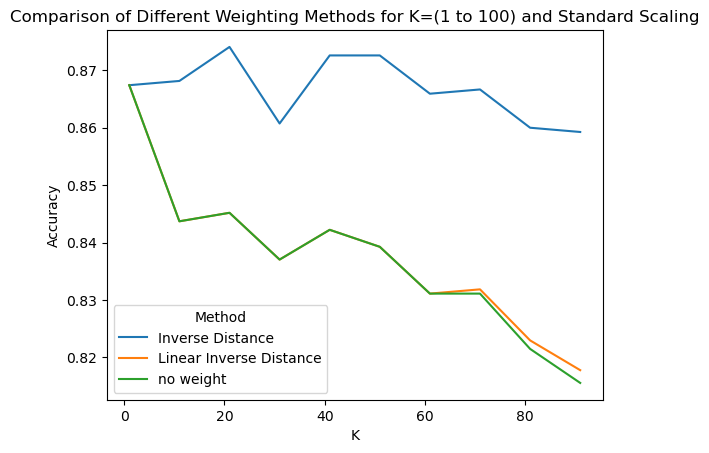

In [31]:

# Predictions for different classifiers




predictions = pd.DataFrame(columns=['K', 'Method', 'Accuracy'])

for k in range(1,100,10):

    prediction_inverse = Knn_Classifier(k, train,test, weighting=inverse_distance)
    prediction_linear = Knn_Classifier(k, train, test, weighting=inverse_linear_distance)
    prediction_normal = Knn_Classifier(k, train, test, weighting=majority_vote)

    for title, prediction in zip(['Inverse Distance', 'Linear Inverse Distance', 'no weight'], [prediction_inverse, prediction_linear, prediction_normal]):
        accuracy_data = [k, title, compute_accuracy(pd.Series(prediction), test['quality'])]

        predictions.loc[predictions.shape[0]] = accuracy_data


print(predictions.head(5))

sns.lineplot(x='K', y='Accuracy', hue='Method', data=predictions,  markers=True).set_title('Comparison of Different Weighting Methods for K=(1 to 100) and Standard Scaling')



In [32]:
train_data = train.iloc[:, :-1]
train_copy: pd.DataFrame = train.copy()

k=50

# finding mismatches
false_indexes_inverse = [int(i) for i,x in  enumerate(prediction_inverse == prediction_normal) if not x]
false_indexes_linear = [int(i) for i,x in  enumerate(prediction_linear == prediction_normal) if not x]

total_false = np.unique(false_indexes_linear + false_indexes_inverse)

mismatches:pd.DataFrame = test.iloc[total_false, :]


for index, row in mismatches.sample(2).iterrows():
    normal = f'[{prediction_normal[index]}]' if row['quality'] == prediction_normal[index] else f' {prediction_normal[index]} '
    inverse = f'[{prediction_inverse[index]}]' if row['quality'] == prediction_inverse[index] else f' {prediction_inverse[index]} '
    linear = f'[{prediction_linear[index]}]' if row['quality'] == prediction_linear[index] else f' {prediction_linear[index]} '

    print(f"\n----- Mismatch at INDEX {index} ----- \nActual: {row['quality']}  |   Normal: {normal} Inverse: {inverse} Linear: {linear}")

    distances = np.sqrt(np.sum((np.array(train_data) - np.array(row[:-1])) ** 2, axis=1))

    train_copy['Distance'] = distances


    print("linear distance")
    inverse_linear_distance(train_copy, k, toPrint=True)

    print("\ninverse distance")
    inverse_distance(train_copy, k, toPrint=True)

    print("\nmajority vote")
    majority_vote(train_copy, k, toPrint=True)



----- Mismatch at INDEX 105 ----- 
Actual: 1.0  |   Normal:  0.0  Inverse: [1.0] Linear:  0.0 
linear distance
[25.97246351 18.96812873]

inverse distance
[1.65324593e+01 1.00001174e+06]

majority vote
[29 21]

----- Mismatch at INDEX 148 ----- 
Actual: 1.0  |   Normal:  0.0  Inverse: [1.0] Linear:  0.0 
linear distance
[37.43069108  7.22759481]

inverse distance
[2.53655978e+01 1.00000405e+06]

majority vote
[42  8]
